In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv('./data/kaggle/train.csv')
df_test = pd.read_csv('./data/kaggle/test.csv')

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Data preprocessing

In [5]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


/home/thang/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.



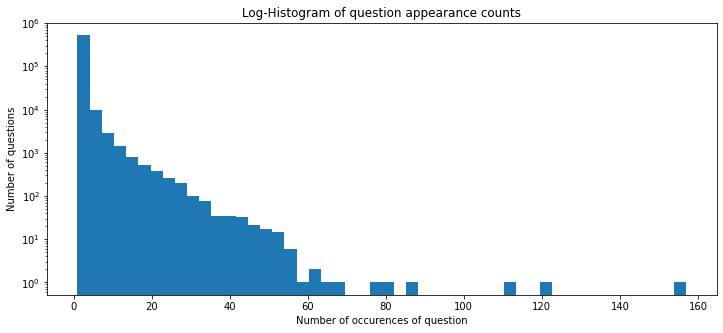

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [7]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

In [10]:
import os
import re
import csv
import codecs

from nltk.corpus import stopwords

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [11]:
texts_1 = [] 
texts_2 = []
labels = []
with codecs.open("./data/kaggle/train.csv", encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in train.csv' % len(texts_1))

Found 404290 texts in train.csv


In [13]:
test_texts_1 = [] 
test_texts_2 = []
test_ids = []
with codecs.open("./data/kaggle/test.csv", encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in test.csv' % len(test_texts_1))

Found 2345796 texts in test.csv


In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 120499 unique tokens


In [ ]:
from keras.preprocessing.sequence import pad_sequences

data_1 = pad_sequences(sequences_1, maxlen=30)
data_2 = pad_sequences(sequences_2, maxlen=30)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=30)
test_data_2 = pad_sequences(test_sequences_2, maxlen=30)
test_ids = np.array(test_ids)

# Basic CNN

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Conv1D, Conv2D, Embedding, Dot
from keras.layers.merge import Concatenate
from keras import backend as K

input1 = Input((data_1.shape[1],))
input2 = Input((data_2.shape[1],))
Embedding_matrix = Embedding(len(word_index)+1, 300, input_length=data_1.shape[1], name="embedding")
z1 = Embedding_matrix(input1)
z2 = Embedding_matrix(input2)
Conv = Conv1D(filters=200,
                    kernel_size=3,
                    padding="valid",
                    activation="relu",
                    strides=1)
conv1 = Conv(z1)
conv2 = Conv(z2)
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)
conv1 = Flatten()(conv1)
conv2 = Flatten()(conv2)
similar_score = Dense(2800, activation=None)(conv1)
similar_score = Dot(1)([similar_score, conv2])
z = Concatenate()([conv1, similar_score, conv2])
z = Dropout(0.8)(z)
z = Dense(100, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)
model = Model([input1, input2], model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
model.fit([data_1, data_2], labels, batch_size=120, epochs=3)

In [ ]:
predict_label = model.predict([test_data_1, test_data_2])

In [ ]:
submission_df = {"test_id": test_ids, "is_duplicate": predict_label[:,0]}
submission = pd.DataFrame(submission_df)
# submission.to_csv("submission.csv", index=False)